## Voice Detection

In [11]:
import os
import numpy as np
import librosa
import tsfel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import joblib

In [12]:
# === Folder data ===
buka_path = "data/voice/buka-voice"
tutup_path = "data/voice/tutup-voice"

# === Load konfigurasi fitur TSFEL ===
cfg = tsfel.get_features_by_domain()  # semua domain: temporal, spectral, statistical

# === Fungsi ekstraksi fitur TSFEL ===
def extract_features_tsfel(file_path):
    # Load file audio
    y, sr = librosa.load(file_path, sr=None)
    
    # Normalisasi panjang sinyal (opsional)
    if len(y) > sr * 5:  # potong jadi 5 detik maksimum
        y = y[:sr * 5]
    
    # Ekstraksi fitur menggunakan TSFEL
    features_df = tsfel.time_series_features_extractor(cfg, y, fs=sr, verbose=0)
    features = features_df.mean(axis=0).values  # ambil mean dari setiap fitur
    
    return features

# === Persiapan data ===
X, y = [], []

print("🔍 Mengekstrak fitur dari folder 'buka-voice' ...")
for file in os.listdir(buka_path):
    if file.endswith(".mp3"):
        file_path = os.path.join(buka_path, file)
        features = extract_features_tsfel(file_path)
        X.append(features)
        y.append(0)

print("🔍 Mengekstrak fitur dari folder 'tutup-voice' ...")
for file in os.listdir(tutup_path):
    if file.endswith(".mp3"):
        file_path = os.path.join(tutup_path, file)
        features = extract_features_tsfel(file_path)
        X.append(features)
        y.append(1)

🔍 Mengekstrak fitur dari folder 'buka-voice' ...
🔍 Mengekstrak fitur dari folder 'tutup-voice' ...


In [13]:
X = np.array(X)
y = np.array(y)

# === Split data untuk training dan testing ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Normalisasi ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

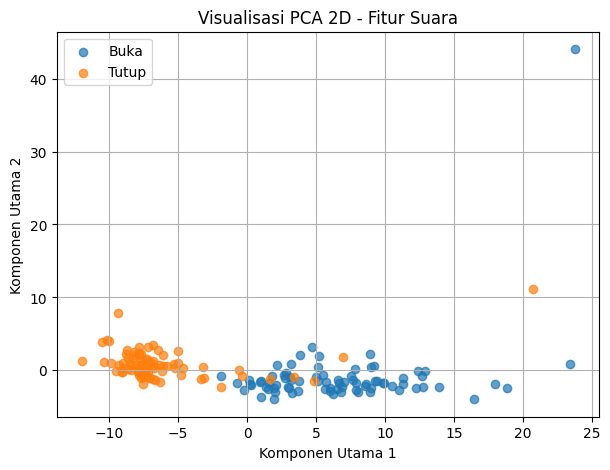

In [14]:
# ==================================================
# 🔹 PCA 2D
# ==================================================
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(
    X_pca_2d[y_train == 0, 0],
    X_pca_2d[y_train == 0, 1],
    label="Buka",
    alpha=0.7
)
plt.scatter(
    X_pca_2d[y_train == 1, 0],
    X_pca_2d[y_train == 1, 1],
    label="Tutup",
    alpha=0.7
)
plt.title("Visualisasi PCA 2D - Fitur Suara")
plt.xlabel("Komponen Utama 1")
plt.ylabel("Komponen Utama 2")
plt.legend()
plt.grid(True)
plt.show()

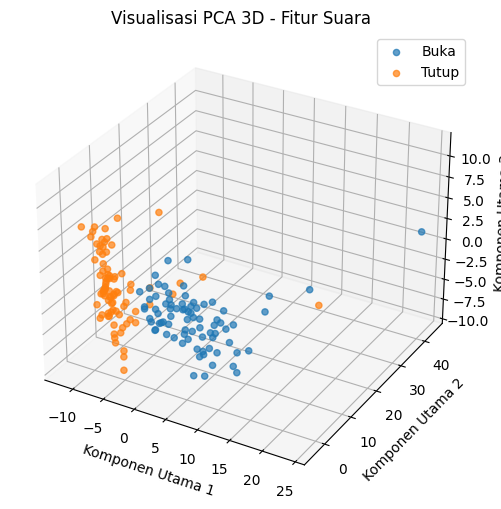

In [15]:
# ==================================================
# 🔹 PCA 3D
# ==================================================
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pca_3d[y_train == 0, 0],
    X_pca_3d[y_train == 0, 1],
    X_pca_3d[y_train == 0, 2],
    label="Buka",
    alpha=0.7
)
ax.scatter(
    X_pca_3d[y_train == 1, 0],
    X_pca_3d[y_train == 1, 1],
    X_pca_3d[y_train == 1, 2],
    label="Tutup",
    alpha=0.7
)
ax.set_title("Visualisasi PCA 3D - Fitur Suara")
ax.set_xlabel("Komponen Utama 1")
ax.set_ylabel("Komponen Utama 2")
ax.set_zlabel("Komponen Utama 3")
ax.legend()
plt.show()

In [16]:
# === Model KNN ===
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

# === Evaluasi ===
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# === Simpan model & scaler jika ingin digunakan ulang ===
joblib.dump(knn, "model_knn_voice.pkl")
joblib.dump(scaler, "scaler.pkl")

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        19

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



['scaler.pkl']

In [16]:
import sounddevice as sd
import wavio
import joblib
import librosa
import numpy as np

duration = 3  # durasi rekam dalam detik
samplerate = 44100  # sample rate umum

print("🎙️ Mulai merekam...")
recording = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='float32')
sd.wait()
print("✅ Rekaman selesai!")

# Simpan hasil rekaman
file_path = "recorded.wav"
wavio.write(file_path, recording, samplerate, sampwidth=2)

# Load model dan scaler
model = joblib.load("model_knn_voice.pkl")
scaler = joblib.load("scaler.pkl")

# Ekstraksi fitur dan prediksi
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc.T, axis=0)

features = extract_features(file_path).reshape(1, -1)
features = scaler.transform(features)

pred = model.predict(features)
print("Prediksi:", "BUKA" if pred[0] == 0 else "TUTUP")


🎙️ Mulai merekam...
✅ Rekaman selesai!
Prediksi: TUTUP
